In [1]:
from keras.datasets import mnist
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from keras.layers import Input, Dense
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from keras.layers import concatenate
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, MaxPooling2D, Dense, UpSampling2D, Reshape, Flatten, BatchNormalization, Lambda
from keras.layers import LeakyReLU, Input, Dropout, Conv2DTranspose
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.applications import ResNet50
from keras import backend as K
from keras import losses
from keras.models import load_model
from keras.regularizers import L1L2
import os
import re

/home/alexey/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
len(x_train)

60000

5


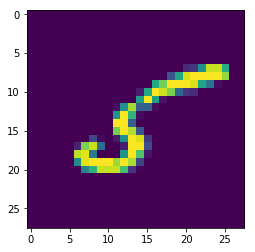

In [4]:
ind = 11
print(y_train[ind])
plt.imshow(x_train[ind])

In [ ]:
#plt.figure(figsize=(12,10))
#plt.scatter(p_field[:, 0], p_field[:, 1], c=images_labels,#color='blue', 
#            edgecolor='none', alpha=0.7, s=40,
#            cmap=plt.cm.get_cmap('nipy_spectral', 10))
#plt.colorbar()
#plt.title('images projection')

#print(p_field.shape)
#print(tsne.get_params(True))

In [5]:
def create_conv_vae(input_shape, latent_dim, dropout_rate, batch_size,
                start_lr=0.001):
    models = {}

    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    input_img = Input(shape=input_shape)

    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(1, (7, 7), activation='relu', padding='same')(x)
    x = Flatten()(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                                  stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    z = Input(shape=(latent_dim,))

    x = Dense(49)(z)
    x = LeakyReLU()(x)
    x = Reshape((7, 7, 1))(x)
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)

    models["encoder"] = Model(input_img, l, 'Encoder')
    models["z_meaner"] = Model(input_img, z_mean, 'Enc_z_mean')
    models["z_lvarer"] = Model(input_img, z_log_var, 'Enc_z_log_var')

    def vae_loss(x, decoded):
        x = K.reshape(x, shape=(batch_size, input_shape[0] * input_shape[1]))
        decoded = K.reshape(decoded, shape=(batch_size, input_shape[0] * input_shape[1]))
        xent_loss = input_shape[0] * input_shape[1]*binary_crossentropy(x, decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss)/2/input_shape[0]/input_shape[1]

    models["decoder"] = Model(z, decoded, name='Decoder')
    models["vae"] = Model(input_img,
                          models["decoder"](models["encoder"](input_img)),
                          name="VAE")

    models["vae"].compile(optimizer=Adam(lr=start_lr), loss=vae_loss)

    return models, vae_loss


def create_vae(input_shape, latent_dim, dropout_rate, batch_size,
                start_lr=0.001):
    models = {}

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    # Энкодер
    input_img = Input(shape=input_shape)
    x = Flatten()(input_img)
    x = Dense(256, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    x = Dense(128, activation='relu')(x)
    x = apply_bn_and_dropout(x)

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, 'Encoder')
    models["z_meaner"] = Model(input_img, z_mean, 'Enc_z_mean')
    models["z_lvarer"] = Model(input_img, z_log_var, 'Enc_z_log_var')

    # Декодер
    z = Input(shape=(latent_dim, ))
    x = Dense(128)(z)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(256)(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(input_shape[0] * input_shape[1], activation='sigmoid')(x)
    decoded = Reshape((input_shape[0], input_shape[1], 1))(x)

    models["decoder"] = Model(z, decoded, name='Decoder')
    models["vae"] = Model(input_img, models["decoder"](models["encoder"](input_img)), name="VAE")

    def vae_loss(x, decoded):
        x = K.reshape(x, shape=(batch_size, input_shape[0] * input_shape[1]))
        decoded = K.reshape(decoded, shape=(batch_size, input_shape[0] * input_shape[1]))
        xent_loss = input_shape[0] * input_shape[1]*binary_crossentropy(x, decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss)/2/input_shape[0]/input_shape[1]

    models["vae"].compile(optimizer=Adam(lr=start_lr), loss=vae_loss)

    return models, vae_loss


def load_last_weights(model, path, logger=None):
    if not os.path.isdir(path):
        os.makedirs(path)

    weights_files_list = [
        matching_f.group()
        for matching_f in map(
            lambda x: re.match('vae-\d+-\d+-\d+-\d+.h5', x),
            os.listdir(path)
        ) if matching_f if not None
    ]

    if len(weights_files_list) == 0:
        return 0

    weights_files_list.sort(key=lambda x: -int(x.split('-')[1]))

    model.load_weights(os.path.join(path, weights_files_list[0]))

    if logger is not None:
        logger.debug('LOAD MODEL PATH: {}'.format(
            os.path.join(path, weights_files_list[0])
        ))
    else:
        print('LOAD MODEL PATH: {}'.format(
            os.path.join(path, weights_files_list[0])
        ))

    return int(weights_files_list[0].split('-')[1])

In [21]:
batch_size = 1000
latentdim = 10

print(create_vae(
        input_shape=(28, 28, 1),
        latent_dim=latentdim,
        dropout_rate=0.4,
        batch_size=batch_size
    )[0]["vae"].summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
Encoder (Model)              (None, 10)                237972    
_________________________________________________________________
Decoder (Model)              (None, 28, 28, 1)         237456    
Total params: 475,428
Trainable params: 473,892
Non-trainable params: 1,536
_________________________________________________________________
None


In [22]:
batch_size = 1000
latentdim = 10
#88

tvae = create_conv_vae

models, loss = tvae(
        input_shape=(28, 28, 1),
        latent_dim=latentdim,
        dropout_rate=0.4,
        batch_size=batch_size
    )

vae = models["vae"]

start_epoch = load_last_weights(vae, '../data/mnist/conv_vae2_weights_ld_10/')
print('START EPOCH NUMBER: {}'.format(start_epoch))

print(vae.summary())

LOAD MODEL PATH: ../data/mnist/conv_vae2_weights_ld_10/vae-304-10-1000-28.h5
START EPOCH NUMBER: 304
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
Encoder (Model)              (None, 10)                25385     
_________________________________________________________________
Decoder (Model)              (None, 28, 28, 1)         24924     
Total params: 50,309
Trainable params: 50,309
Non-trainable params: 0
_________________________________________________________________
None


In [167]:
from keras.utils import plot_model
plot_model(models['encoder'], to_file='../data/plots/encoder_conv_vae_10.png', show_shapes=True)

In [23]:
X = np.array(x_train[0:5000]).reshape(5000, 28, 28, 1) / 255. 
y = y_train[0:5000] 
X_encode = models['z_meaner'].predict(X, batch_size=1000)

(5000, 2)


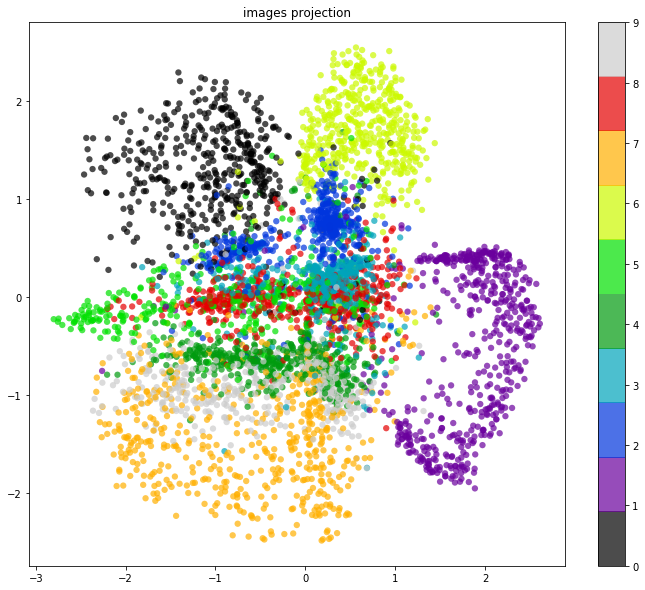

In [127]:
#VAE latent dimention 2
data = X_encode

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1)

p_field = tsne.fit_transform(X_encode)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.495s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.789168
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.602638
[t-SNE] Error after 1000 iterations: 1.474025


(5000, 10)


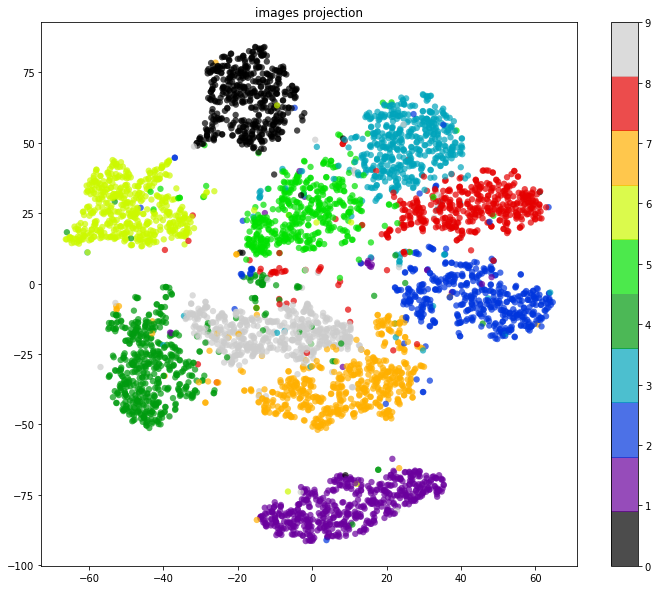

In [25]:
#Convolutional VAE version 2 latent dimention 10 on 73 epoch
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

(5000, 32)


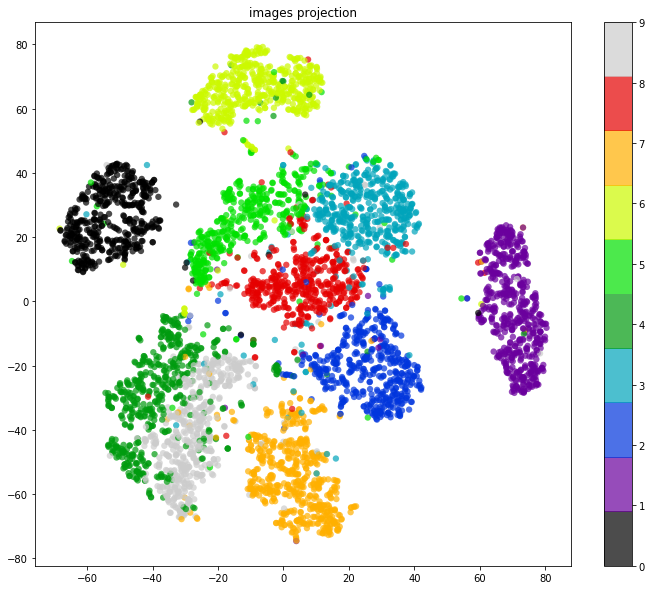

In [190]:
#VAE latent dimention 32 on 500 epoch
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

(5000, 32)


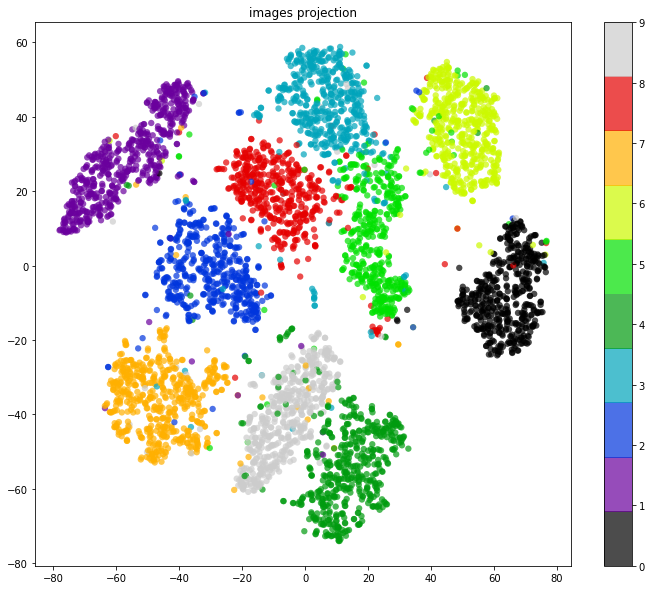

In [184]:
#Convolution VAE latent dimention 32 on 500 epoch
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

(5000, 10)


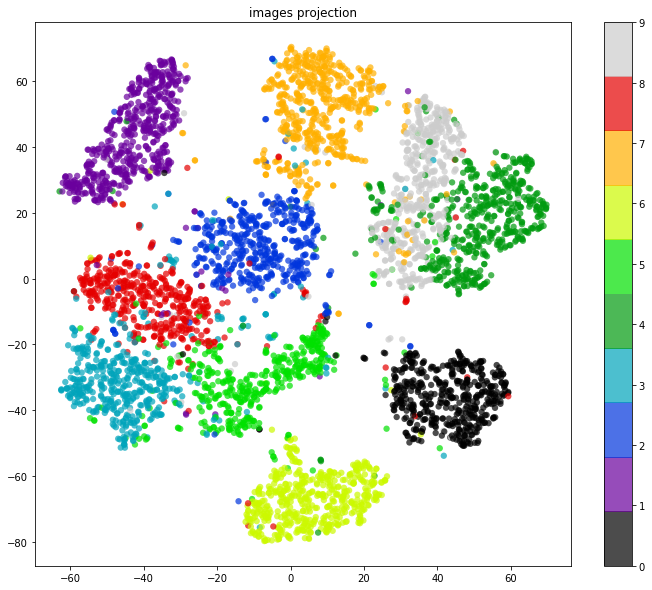

In [180]:
#Convolution VAE latent dimention 10 on 500 epoch
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

(5000, 10)


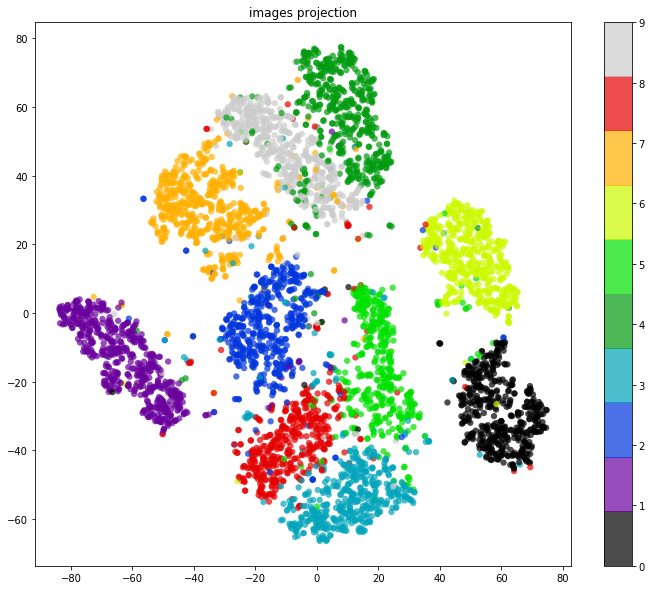

In [152]:
#Convolution VAE latent dimention 10 on 233 epoch
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

(5000, 10)


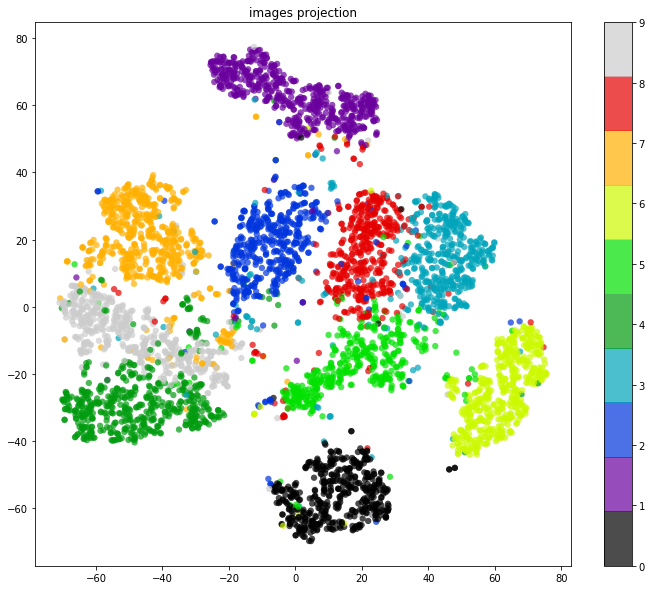

In [144]:
#Convolution VAE latent dimention 10 on 88 epoch
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

(5000, 10)


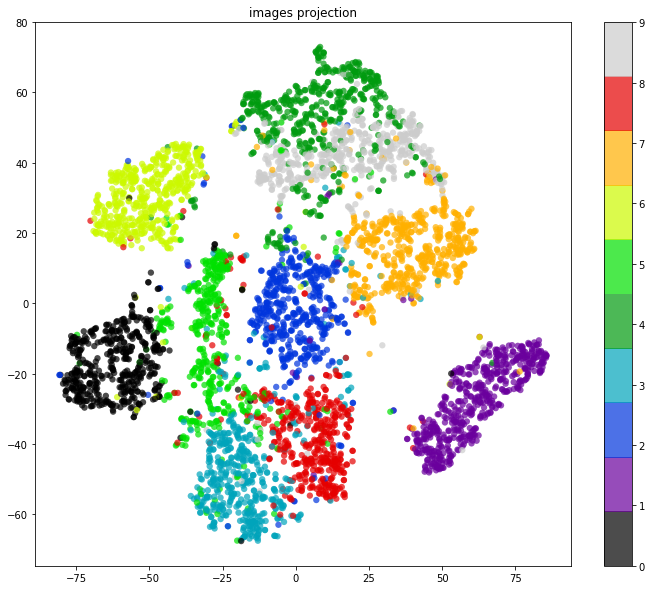

In [119]:
#VAE latent dimention 10
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.509s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.867905
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.852013
[t-SNE] Error after 1000 iterations: 1.885289
(5000, 10)


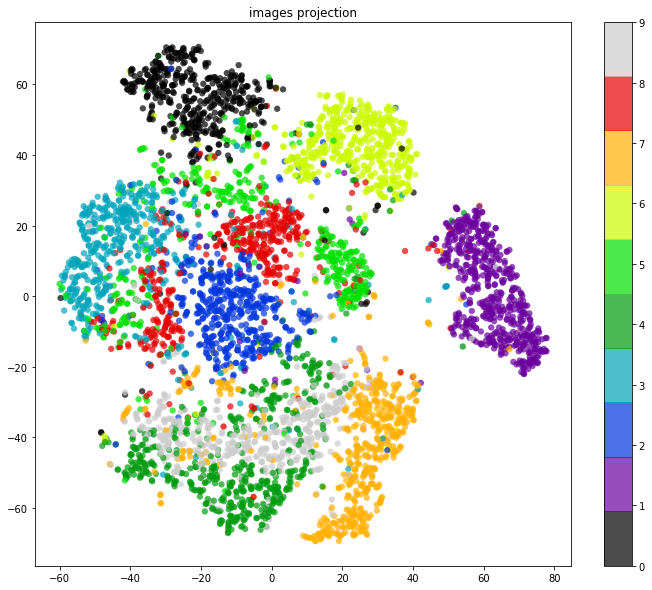

In [124]:
#VAE latent dimention 10 with logvar
X_encode = models['encoder'].predict(X, batch_size=1000)
tsne = TSNE(n_components=2, verbose=1)

p_field = tsne.fit_transform(X_encode)

data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

In [120]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
p_field = pca.fit_transform(X_encode)

(5000, 10)


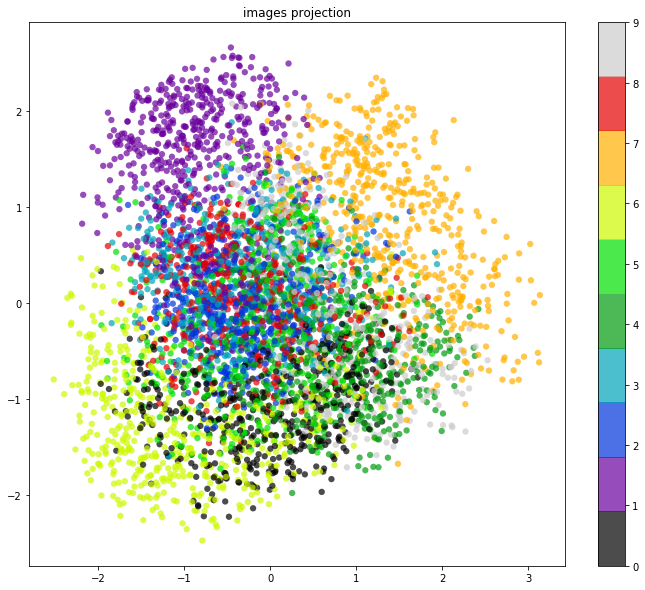

In [121]:
#VAE latent dimention 10 by PCA clustering
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

print(X_encode.shape)

[(2, 0.6101869810934912), (3, 0.7214155460405066), (4, 0.5209524484730591), (5, 0.8800512549887501), (6, 0.8864204788518165), (7, 0.6355507641119316), (8, 0.6989061838537549), (9, 0.92151514302123), (10, 0.8999969242238497), (11, 0.8532319949191769)]


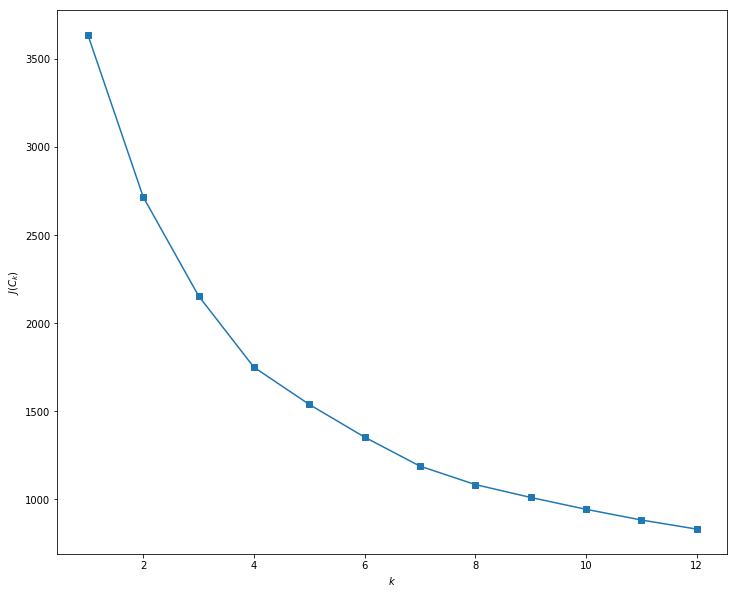

In [170]:
from sklearn.cluster import KMeans

N = [i + 1 for i in range(12)]
inertia = []
for k in N:
    kmeans = KMeans(n_clusters=k, random_state=1, n_jobs=4).fit(p_field)
    inertia.append(np.sqrt(kmeans.inertia_))

d_list = [(i + 1, abs((inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])))  for i in range(1, len(inertia) - 1)]
print(d_list)

plt.figure(figsize=(12,10))
plt.plot(N, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');